In [25]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [16]:
# storing 
import numpy as np
import pandas as pd
import calmap
import warnings
import wget
import os
import shutil
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU, WeekdayLocator
from scipy.fftpack import fft
from scipy.signal import butter, lfilter, freqz, stft
warnings.filterwarnings('ignore')
dataPath = '../data/'
pd.set_option('display.max_columns', None)
from IPython.display import HTML

#### 0. Functions
- Run below cell once

In [22]:
{
    "tags": [
        "hide_input",
    ]
}

def Update_Data():
    urls = ['https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv', 
            'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv']

    for url in urls:
        filename = wget.download(url)
        os.remove(dataPath + filename)
        newPath = shutil.move(filename, dataPath[0:-1])
        
    conf_df = pd.read_csv(dataPath + 'time_series_covid19_confirmed_global.csv')
    deaths_df = pd.read_csv(dataPath + 'time_series_covid19_deaths_global.csv') 
    
    return conf_df, deaths_df

# -------------------------------------------------------------------------------------------------------------------------------------------------------------------

def create_changes_dataframe(df):

    province_states_unique = df["Province/State"].unique()#.dropna().unique()
    dfAggregates = df[df['Province/State'].isin(province_states_unique)]
    country_region_aggregates = dfAggregates['Country/Region'].unique()

    for i, agg_country in enumerate(country_region_aggregates):
        lstRow = []
        dfTemp = dfAggregates[dfAggregates['Country/Region'] == agg_country]
        provState = agg_country + '_Total'
        lat = dfTemp.Lat.sum()/len(dfTemp)
        long = dfTemp.Long.sum()/len(dfTemp)
        rowEntries = [provState, agg_country, lat, long]
        lstRow = [elem for elem in rowEntries] 
        for col in dfTemp.columns[4:]:
            col_j_aggregate = dfTemp[col].sum()
            lstRow.append(col_j_aggregate)
        lstRow = pd.DataFrame([lstRow], columns = dfTemp.columns)
        df = df.append(lstRow)


    df = df.sort_values(by = "Country/Region") 
    df['Province/State'].fillna(df['Country/Region'] + '_Mainland', inplace=True)
    df = df.reset_index(drop = True)
    df[df['Country/Region'] == 'United Kingdom'].tail(2)

    col_list = df.columns[0:4].tolist()
    for col in df.columns[4:]:
        if len(col) == 7:
            col = "Diff_Prev_Day_" + col[2:4] + col[1] + col[0]
        elif len(col) == 6:
            col = "Diff_Prev_Day_" + col[2:3] + col[1] + col[0]
        col_list.append(col)

    df_daily_change = pd.DataFrame(columns = col_list)
    countries_unique = df["Country/Region"].unique()
    growth_rates = []
    prevNum = 0
    len_max = len(df.columns[4:])

    for country in countries_unique:
        
        df_country = df[df["Country/Region"] == country]
        province_states_unique = df_country["Province/State"].dropna()

        for province_state in province_states_unique:
            day_change_lst = []
            df_province_state = df_country[df_country["Province/State"] == province_state]
            day_change_lst = df_province_state[df_province_state.columns[0:4]].values.tolist()
            #print((growth_rate_daily))
            # When only country info is available:
            if len(day_change_lst) == 0:
                df_province_state = df_country
                day_change_lst = df_country[df_country.columns[0:4]].values.tolist()

            df_province_state = df_province_state.loc[:, (df_province_state != 0).any(axis=0)]
            #print(growth_rate_daily)
            mod_list = []
            for i, elem in enumerate(day_change_lst):
                if type(elem) == list:
                    for j, elem_ in enumerate(elem):
                        mod_list.append(elem_)
                else:
                    mod_list.append(elem)
            day_change_lst = mod_list

            prevNum = 0
            len_df_province = len(df_province_state.columns[4:])
            diff = len_max - len_df_province
            day_change_lst += [0.] * (diff) 
            #print(len(df_province_state.columns[4:]))
            for col in df_province_state.columns[4:]:
                new_num_cases = df_province_state[col].values[0]

                if prevNum > 0:
                    #growth_rate_day = 100*(new_num_cases - prevNum) / prevNum
                    growth_rate_day = new_num_cases - prevNum

                else:
                    growth_rate_day = 0

                day_change_lst.append(growth_rate_day)
                prevNum = new_num_cases

            df_day_i_change = pd.DataFrame([day_change_lst], columns = col_list)

            if len(df_daily_change) == 0:
                df_daily_change = df_day_i_change
            else:
                df_daily_change = pd.concat([df_daily_change, df_day_i_change])

            
    return df_daily_change

# -------------------------------------------------------------------------------------------------------------------------------------------------------------------

def plotDailyChanges(df_daily_change, list_countries, colourList, axislabels, filterInputs):
    df_plot = pd.DataFrame()
    filtering = filterInputs[0]
    Ts = filterInputs[1]
    order = filterInputs[2]
    cutoff = filterInputs[3]
    inputVariable = "DayChanges"
    #colours = ['b', 'g', 'r', 'y', 'orange', 'cyan', 'magenta', [255, 5, 24]]#,  'y', 'orange', 'cyan', 'b',  'y', 'orange', 'cyan']#[255, 5, 24]]
    #colours = [getcolour(), getcolour(), getcolour(), getcolour(), getcolour(), getcolour(), getcolour(), getcolour(), getcolour(), getcolour()]
    f = plt.figure(figsize=(20,10))
    ax = f.add_subplot("111")
    base = datetime.date(2020, 1, 22)
    numdays = len(df_daily_change.columns[4:])
    date_list = [base + datetime.timedelta(days=x) for x in range(numdays)]
    province_states_unique = df_daily_change["Province/State"].unique()

    j = 0
    for province_state in province_states_unique:
        df_province_state = df_daily_change[df_daily_change["Province/State"] == province_state]
        dayChanges = df_province_state[df_province_state.columns[4:]].values[0].tolist()


        if max(dayChanges) > 0 and (province_state in list_countries):
            #j += 1
            if j%1 == 0:
                colour = colourList[j]
                j += 1
                df_plot["dates"] = date_list
                df_plot["DayChanges"] = dayChanges
                #df_plot["growth_rates"] = df_plot["growth_rates"].rolling(3).mean()
                if filtering:
                    y_filtered = lowPass_butterworth(df_plot, inputVariable, cutoff, order, Ts)
                    df_plot["y_filtered"] = y_filtered
                    df_plot["y_filtered"] = df_plot["y_filtered"].rolling(3).mean()
                    if j%2 == 0:
                        plt.plot(df_plot.dates,  df_plot["y_filtered"], "-o", color = colour, label = province_state, markersize = 6, alpha = 1)
                    else:
                        plt.plot(df_plot.dates,  df_plot["y_filtered"], "->", color = colour, label = province_state, markersize = 6, alpha = 1)
                else:
                     plt.plot(df_plot.dates, df_plot.DayChanges, "-o", color = colour, label = province_state, markersize = 6, alpha = 1)
              
            #break
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    #import matplotlib.dates.WeekdayLocator
    # tick on mondays every week
    #loc = WeekdayLocator(byweekday=MO, tz=tz)

    # tick on mondays and saturdays
    loc = WeekdayLocator(byweekday=(MO,FR))
    ax.xaxis.set_major_locator(loc)
    plt.xticks(rotation=45)
    plt.ylabel(axislabels[0], size = 15)
    plt.xlabel("Date", size = 15)
    #plt.xlim(df_plot.dates[15], df_plot.dates[len(df_plot.dates) - 1])
    plt.gca().set_xlim(left=df_plot.dates[20])
    plt.title(axislabels[1], size = 20)
    #plt.ylim([-1, 100])
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.show()
    

# -------------------------------------------------------------------------------------------------------------------------------------------------------------------

def getcolour():
    return np.random.rand(3,)

# -------------------------------------------------------------------------------------------------------------------------------------------------------------------

def lowPass_butterworth(io_signal, inputVariable, cutoff, order, Ts):
    #### Try cut-off frequency of cutoff units

    # Signal
    variable = inputVariable #+ str(gainNum) 
    
    # Detrend
    y = io_signal[variable].dropna() - (io_signal[variable].dropna()).sum() / len(io_signal[variable].dropna())
    #print(y[0:5])
    # Sample-rate
    fs = 1 / Ts
    #print(fs)
    # Low-pass calculation
    b, a = butter_lowpass(cutoff, fs, order=order)
    y_butter = lfilter(b, a, y) + (io_signal[variable].dropna()).sum() / len(io_signal[variable].dropna())
    offset = min(y.dropna().index.values)

    #brewCycle = np.linspace(0, brew_curr.BrwDurationSec.dropna(), len(brew_curr.BrwDurationSec.dropna()), endpoint=False)
    #sample = np.linspace(offset, len(y_butter) + offset, len(y_butter), endpoint=False)
    
    return y_butter

# -------------------------------------------------------------------------------------------------------------------------------------------------------------------

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

# ---------------------------------------------------------------------------------------------------------------------

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

#### 1. Update Datasets
- Run below cell once

In [10]:
conf_df, deaths_df = Update_Data()
df_daily_change_conf = create_changes_dataframe(conf_df.copy())
df_daily_change_death = create_changes_dataframe(deaths_df.copy())

100% [..........................................................] 49393 / 49393

#### 2. Number of new-deaths per day

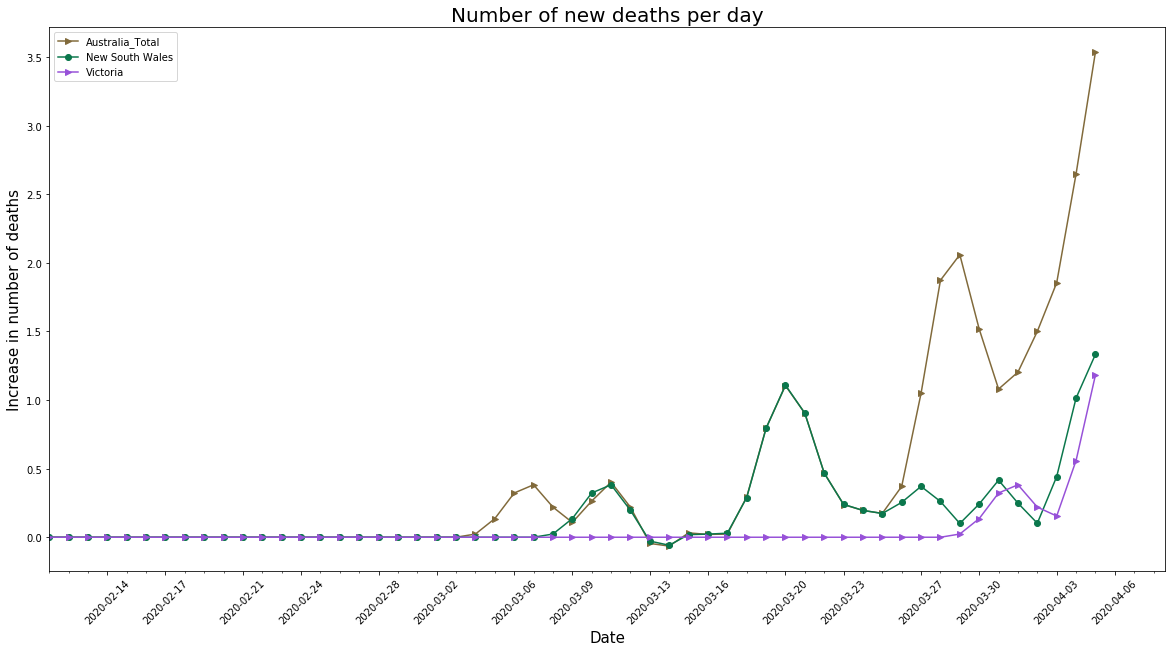

In [23]:
list_countries = ['France_Mainland', 'US_Mainland', 'Germany_Mainland', 'Italy_Mainland', 'United Kingdom_Mainland', 'Australia_Total', 'Victoria', 'New South Wales', 'Spain_Mainland']
list_countries = ['Australia_Total', 'Victoria', 'New South Wales']

#if 'US_Mainland' in list_countries: list_countries.remove('US_Mainland')
colourList = []
for i in range(0, len(list_countries)+1):
    colourList.append(getcolour())
axislabels = ["Increase in number of deaths", "Number of new deaths per day"]
filtering = True
Ts = 1 
order = 6  
cutoff = 0.3
filterInputs = [filtering, Ts, order, cutoff]
plotDailyChanges(df_daily_change_death, list_countries, colourList, axislabels, filterInputs)

#### 3. Number of new-cases per day

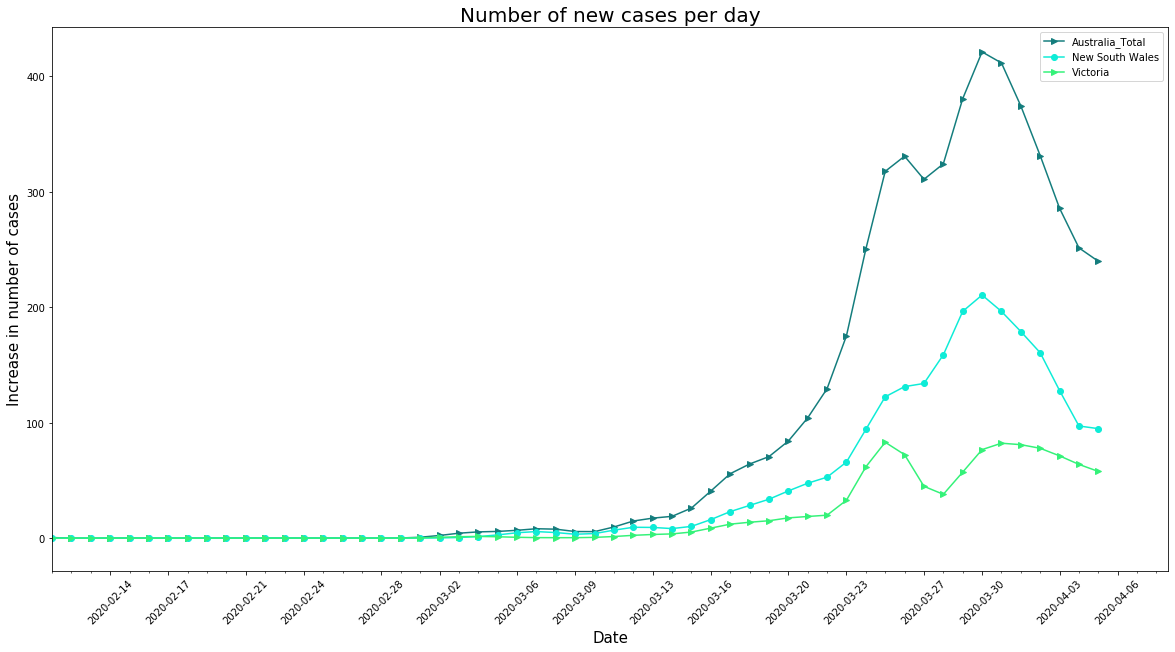

In [24]:
list_countries = ['France_Mainland', 'US_Mainland', 'Italy_Mainland', 'United Kingdom_Mainland', 'Australia_Total', 'Victoria', 'New South Wales', 'Spain_Mainland']
#if 'US_Mainland' in list_countries: list_countries.remove('US_Mainland')
list_countries = ['Australia_Total', 'Victoria', 'New South Wales']
colourList = []
for i in range(0, len(list_countries)+1):
    colourList.append(getcolour())
axislabels = ["Increase in number of cases", "Number of new cases per day"]
filtering = True
Ts = 1 
order = 6  
cutoff = 0.25 
filterInputs = [filtering, Ts, order, cutoff]
plotDailyChanges(df_daily_change_conf, list_countries, colourList, axislabels, filterInputs)